HISTOGRAM

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import zipfile
import os

# Path to the ZIP file
zip_file_path = '/content/drive/My Drive/Soft Computing Resources/AlgX3_64x64_merged_tensors_with_labels.zip'
extract_path = '/content/'

# Verify if the ZIP file exists
if not os.path.exists(zip_file_path):
    raise FileNotFoundError(f"File not found: {zip_file_path}")

# Copy the ZIP file to Colab
!cp "{zip_file_path}" /content

# Unzip the file
with zipfile.ZipFile('/content/AlgX3_64x64_merged_tensors_with_labels.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_path)


Mounted at /content/drive


In [ ]:
pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 11.4 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

# Paths
heatmaps_dir = '/content/AlgX3_64x64_merged_tensors_with_labels'
categories = ['0', '1']

# Parameters
img_size = 64
sequence_length = img_size * img_size  # 64 * 64
batch_size = 32
epochs = 50

# Initialize lists to hold image data and labels
images = []
labels = []

# Read images and labels
for category in categories:
    category_path = os.path.join(heatmaps_dir, category)
    for filename in os.listdir(category_path):
        if filename.endswith('.png'):
            # Load image
            img_path = os.path.join(category_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
            img = cv2.resize(img, (img_size, img_size))  # Ensure the image is 64x64

            # Convert image to 1D array
            img_array = img_to_array(img).flatten()  # Flatten to 1D

            # Append to lists
            images.append(img_array)
            labels.append(int(category))

# Convert lists to NumPy arrays
X = np.array(images)
y = np.array(labels)

# Normalize the pixel values to [0, 1]
X = X / 255.0

# Reshape X to fit into 1D CNN (num_samples, sequence_length, num_features)
X = X.reshape((X.shape[0], sequence_length, 1))

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Conv1D(
        filters=hp.Int('filters_1', min_value=32, max_value=128, step=16),
        kernel_size=hp.Int('kernel_size_1', min_value=3, max_value=7, step=2),
        activation='relu',
        input_shape=(sequence_length, 1)
    ))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(
        filters=hp.Int('filters_2', min_value=32, max_value=128, step=16),
        kernel_size=hp.Int('kernel_size_2', min_value=3, max_value=7, step=2),
        activation='relu'
    ))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(
        filters=hp.Int('filters_3', min_value=32, max_value=128, step=16),
        kernel_size=hp.Int('kernel_size_3', min_value=3, max_value=7, step=2),
        activation='relu'
    ))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=32),
        activation='relu'
    ))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Define the tuner for Bayesian optimization
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Set the number of trials to 10
    directory='bayesian_tuning',
    project_name='cnn_1d'
)

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Perform the search
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
loss, accuracy = best_model.evaluate(X_val, y_val)
print(f'Best Validation Accuracy: {accuracy:.2f}')

# Print the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")

# Save the best model
best_model.save('/content/cnn_1d_model_best.h5')


Reloading Tuner from bayesian_tuning/cnn_1d/tuner0.json
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9223 - loss: 0.2239


Best Validation Accuracy: 0.92
Best Hyperparameters:
filters_1: 112
kernel_size_1: 7
filters_2: 32
kernel_size_2: 5
filters_3: 128
kernel_size_3: 5
dense_units: 64


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.93       778
           1       0.97      0.87      0.92       769

    accuracy                           0.92      1547
   macro avg       0.93      0.92      0.92      1547
weighted avg       0.93      0.92      0.92      1547



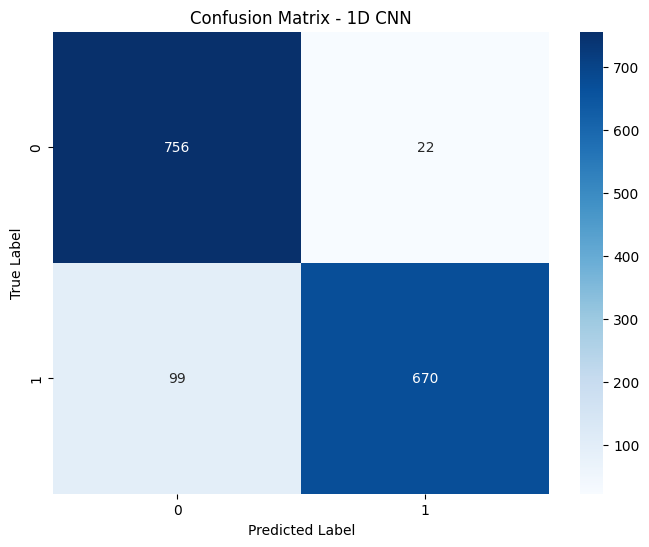

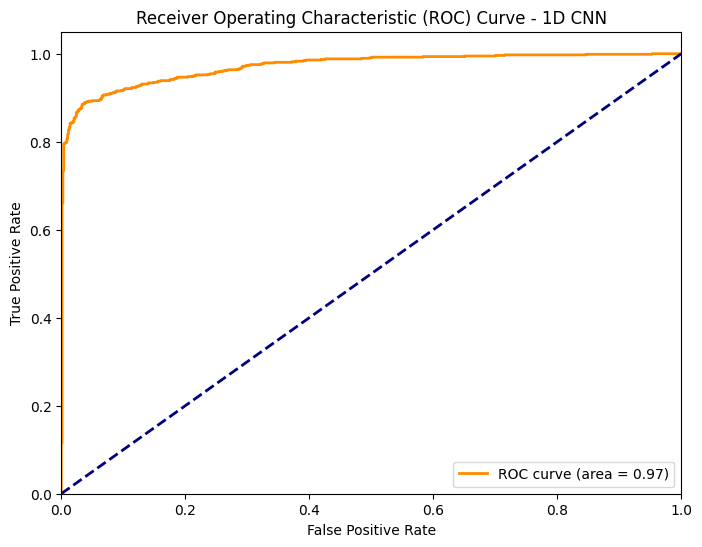

Best Hyperparameters:
filters_1: 112
kernel_size_1: 7
filters_2: 32
kernel_size_2: 5
filters_3: 128
kernel_size_3: 5
dense_units: 64
Best Validation Accuracy: 0.92


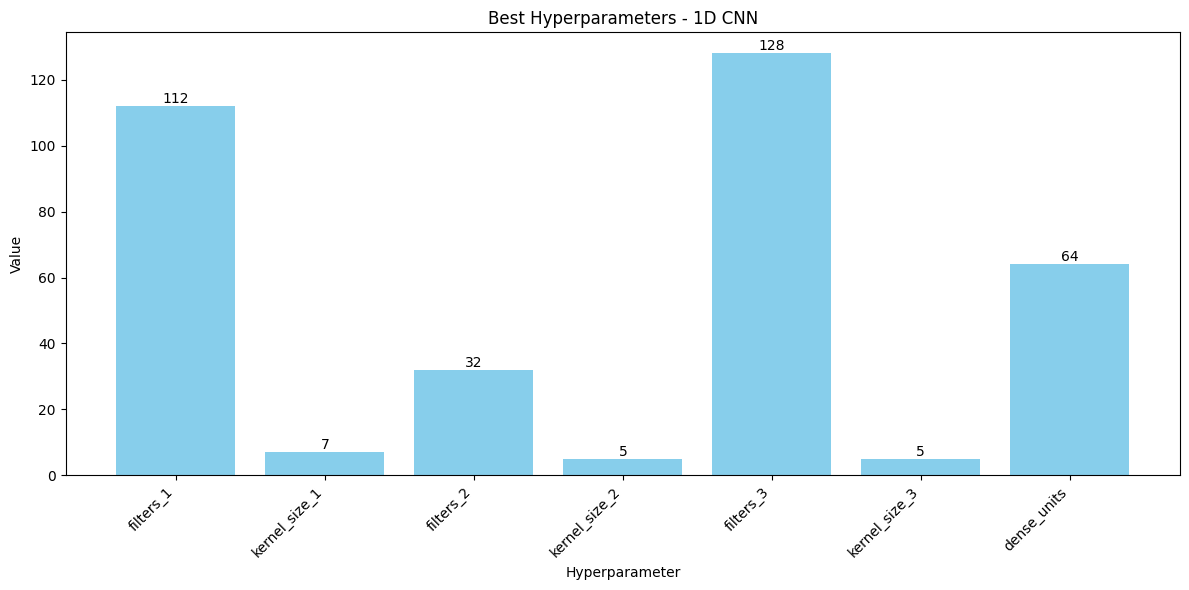

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

# Generate predictions
y_pred = best_model.predict(X_val)
y_pred_classes = np.round(y_pred).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_pred_classes, target_names=categories))

# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix - 1D CNN')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('/content/confusion_matrix.png')  # Save confusion matrix plot
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - 1D CNN')
plt.legend(loc='lower right')
plt.savefig('/content/roc_curve.png')  # Save ROC curve plot
plt.show()

# Print the best parameters
print("Best Hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")

# Print the best validation accuracy
print(f'Best Validation Accuracy: {accuracy:.2f}')

# Plot best hyperparameters with value annotations
hyperparameters = best_hyperparameters.values
keys = list(hyperparameters.keys())
values = [int(value) for value in hyperparameters.values()]  # Convert values to integers

plt.figure(figsize=(12, 6))
bars = plt.bar(keys, values, color='skyblue')

# Adding value annotations on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval}', ha='center', va='bottom')  # Show as integer

plt.xlabel('Hyperparameter')
plt.ylabel('Value')
plt.title('Best Hyperparameters - 1D CNN')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/content/best_hyperparameters.png')  # Save hyperparameters plot
plt.show()


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import kerastuner as kt

# Paths
base_dir = '/content/AlgX3_64x64_merged_tensors_with_labels'
categories = ['0', '1']

# Parameters
img_size = 64
batch_size = 32
epochs = 50

# Data Generator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Split the data into 80% training and 20% validation
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Now split 80% of the training set further into 80% train and 20% test
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)  # 0.25 of training = 20% of original

train_generator_further = test_datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Define model building function for KerasTuner
def build_model(hp):
    model = Sequential([
        Conv2D(hp.Int('filters1', min_value=32, max_value=64, step=32), (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(hp.Int('filters2', min_value=64, max_value=128, step=64), (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(hp.Int('filters3', min_value=128, max_value=256, step=128), (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(hp.Int('units', min_value=256, max_value=512, step=128), activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-1, sampling='LOG')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Initialize Keras Tuner
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='/content/keras_tuner',
    project_name='cnn_tuning'
)

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Search for the best hyperparameters
tuner.search(
    train_generator_further,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=[early_stopping]
)

# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Evaluate the best model on the validation and test sets
val_loss, val_accuracy = best_model.evaluate(validation_generator)
test_loss, test_accuracy = best_model.evaluate(test_generator)

# Save the best model
best_model.save('/content/2d_cnn_model_best.h5')

# Save only validation accuracy
print(f'Validation Accuracy: {val_accuracy:.2f}')
print(f'Test Accuracy: {test_accuracy:.2f}')

# Print the best hyperparameters
print("Best hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")


Trial 10 Complete [00h 03m 07s]
val_accuracy: 0.9107373952865601

Best val_accuracy So Far: 0.9191461801528931
Total elapsed time: 00h 15m 12s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9225 - loss: 0.2142
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9123 - loss: 0.2249


Validation Accuracy: 0.92
Test Accuracy: 0.92
Best hyperparameters:
filters1: 64
filters2: 128
filters3: 256
units: 512
learning_rate: 0.00015922777376687228


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Calculated Accuracy: 0.5103
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.52      0.52       780
           1       0.51      0.50      0.50       766

    accuracy                           0.51      1546
   macro avg       0.51      0.51      0.51      1546
weighted avg       0.51      0.51      0.51      1546



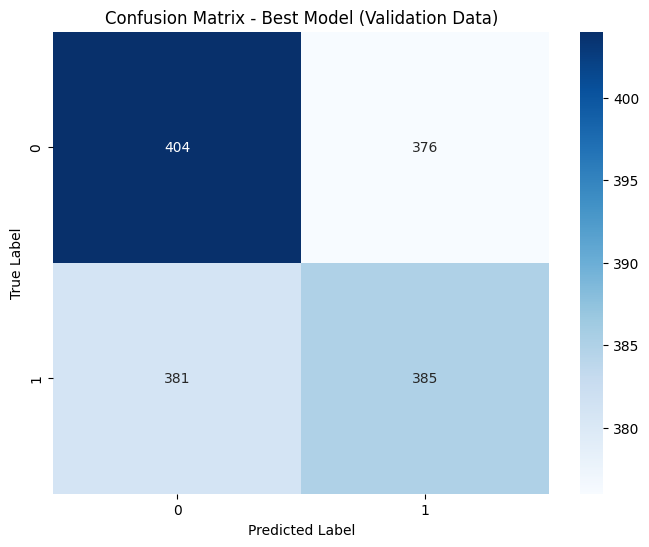

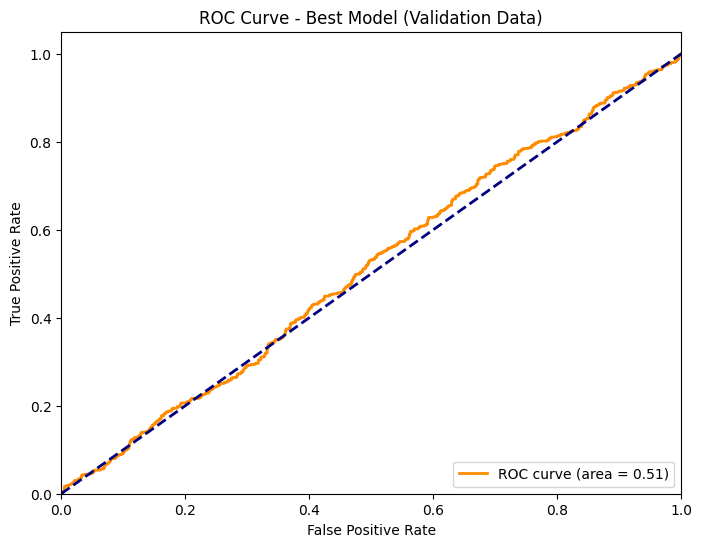

Best Hyperparameters:
filters1: 64
filters2: 128
filters3: 256
units: 512
learning_rate: 0.00015922777376687228


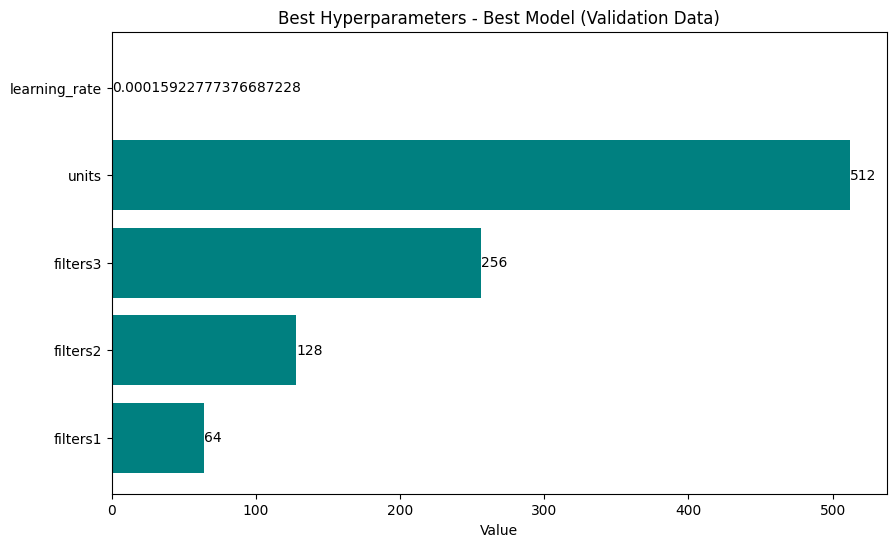

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

# Generate predictions using the best model on the validation set
y_pred = best_model.predict(validation_generator)
y_pred_classes = np.round(y_pred).astype(int)  # Convert probabilities to binary predictions (0 or 1)
y_true = validation_generator.classes  # True labels
categories = list(validation_generator.class_indices.keys())  # Class names (e.g., '0' and '1')

# Calculate accuracy
accuracy = np.mean(y_pred_classes.flatten() == y_true)
print(f"Calculated Accuracy: {accuracy:.4f}")

# Print Classification Report
report = classification_report(y_true, y_pred_classes, target_names=categories)
print("Classification Report:")
print(report)

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix - Best Model (Validation Data)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Best Model (Validation Data)')
plt.legend(loc='lower right')
plt.show()

# Best Hyperparameters
best_params = {
    'filters1': int(best_hyperparameters.get('filters1')),
    'filters2': int(best_hyperparameters.get('filters2')),
    'filters3': int(best_hyperparameters.get('filters3')),
    'units': int(best_hyperparameters.get('units')),
    'learning_rate': best_hyperparameters.get('learning_rate')
}

print("Best Hyperparameters:")
for key, value in best_params.items():
    print(f"{key}: {value}")

# Plot Best Hyperparameters
plt.figure(figsize=(10, 6))
params = list(best_params.keys())
values = list(best_params.values())
plt.barh(params, values, color='teal')

# Annotate values on the bar plot
for index, value in enumerate(values):
    plt.text(value, index, str(value), va='center', ha='left', fontsize=10, color='black')

plt.xlabel('Value')
plt.title('Best Hyperparameters - Best Model (Validation Data)')
plt.show()


HEATMAPS

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import zipfile
import os

# Path to the ZIP file
zip_file_path = '/content/drive/My Drive/Heatmaps/heatmaps.zip'
extract_path = '/content/heatmaps'

# Verify if the ZIP file exists
if not os.path.exists(zip_file_path):
    raise FileNotFoundError(f"File not found: {zip_file_path}")

# Copy the ZIP file to Colab
!cp "{zip_file_path}" /content

# Unzip the file
with zipfile.ZipFile('/content/heatmaps.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

# Paths
heatmaps_dir = '/content/heatmaps'
categories = ['0', '1']

# Parameters
img_size = 64
sequence_length = img_size * img_size  # 64 * 64
batch_size = 32
epochs = 50

# Initialize lists to hold image data and labels
images = []
labels = []

# Read images and labels
for category in categories:
    category_path = os.path.join(heatmaps_dir, category)
    for filename in os.listdir(category_path):
        if filename.endswith('.png'):
            # Load image
            img_path = os.path.join(category_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
            img = cv2.resize(img, (img_size, img_size))  # Ensure the image is 64x64

            # Convert image to 1D array
            img_array = img_to_array(img).flatten()  # Flatten to 1D

            # Append to lists
            images.append(img_array)
            labels.append(int(category))

# Convert lists to NumPy arrays
X = np.array(images)
y = np.array(labels)

# Normalize the pixel values to [0, 1]
X = X / 255.0

# Reshape X to fit into 1D CNN (num_samples, sequence_length, num_features)
X = X.reshape((X.shape[0], sequence_length, 1))

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Conv1D(
        filters=hp.Int('filters_1', min_value=32, max_value=128, step=16),
        kernel_size=hp.Int('kernel_size_1', min_value=3, max_value=7, step=2),
        activation='relu',
        input_shape=(sequence_length, 1)
    ))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(
        filters=hp.Int('filters_2', min_value=32, max_value=128, step=16),
        kernel_size=hp.Int('kernel_size_2', min_value=3, max_value=7, step=2),
        activation='relu'
    ))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(
        filters=hp.Int('filters_3', min_value=32, max_value=128, step=16),
        kernel_size=hp.Int('kernel_size_3', min_value=3, max_value=7, step=2),
        activation='relu'
    ))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=32),
        activation='relu'
    ))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Define the tuner for Bayesian optimization
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Set the number of trials to 10
    directory='bayesian_tuning',
    project_name='cnn_1d'
)

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Perform the search
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
loss, accuracy = best_model.evaluate(X_val, y_val)
print(f'Best Validation Accuracy: {accuracy:.2f}')

# Print the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")

# Save the best model
best_model.save('/content/cnn_1d_model_best.h5')


Trial 10 Complete [00h 00m 15s]
val_accuracy: 0.9100000262260437

Best val_accuracy So Far: 0.9100000262260437
Total elapsed time: 00h 02m 20s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8744 - loss: 0.3254


Best Validation Accuracy: 0.91
Best Hyperparameters:
filters_1: 128
kernel_size_1: 5
filters_2: 48
kernel_size_2: 5
filters_3: 64
kernel_size_3: 7
dense_units: 224


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90        96
           1       0.88      0.96      0.92       104

    accuracy                           0.91       200
   macro avg       0.92      0.91      0.91       200
weighted avg       0.91      0.91      0.91       200



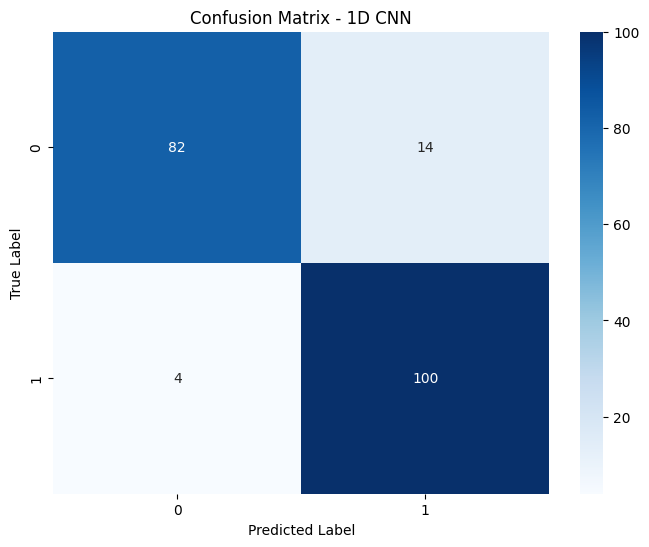

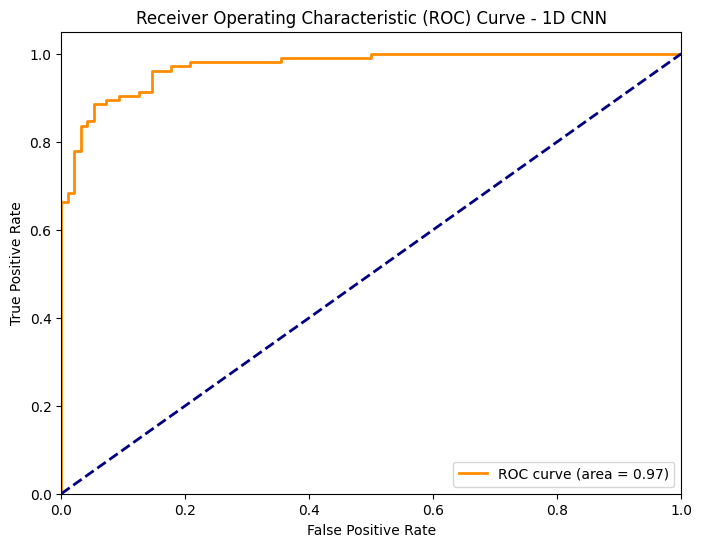

Best Hyperparameters:
filters_1: 128
kernel_size_1: 5
filters_2: 48
kernel_size_2: 5
filters_3: 64
kernel_size_3: 7
dense_units: 224
Best Validation Accuracy: 0.91


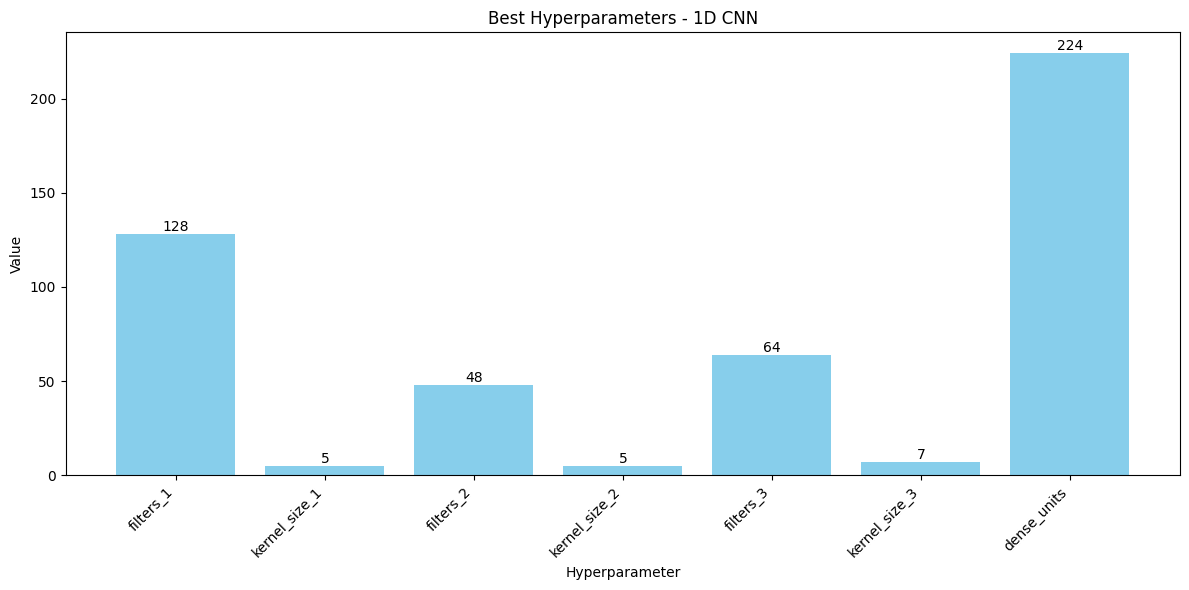

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

# Generate predictions
y_pred = best_model.predict(X_val)
y_pred_classes = np.round(y_pred).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_pred_classes, target_names=categories))

# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix - 1D CNN')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('/content/confusion_matrix.png')  # Save confusion matrix plot
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - 1D CNN')
plt.legend(loc='lower right')
plt.savefig('/content/roc_curve.png')  # Save ROC curve plot
plt.show()

# Print the best parameters
print("Best Hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")

# Print the best validation accuracy
print(f'Best Validation Accuracy: {accuracy:.2f}')

# Plot best hyperparameters with value annotations
hyperparameters = best_hyperparameters.values
keys = list(hyperparameters.keys())
values = [int(value) for value in hyperparameters.values()]  # Convert values to integers

plt.figure(figsize=(12, 6))
bars = plt.bar(keys, values, color='skyblue')

# Adding value annotations on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval}', ha='center', va='bottom')  # Show as integer

plt.xlabel('Hyperparameter')
plt.ylabel('Value')
plt.title('Best Hyperparameters - 1D CNN')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/content/best_hyperparameters.png')  # Save hyperparameters plot
plt.show()


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import kerastuner as kt

# Paths
base_dir = '/content/heatmaps'
categories = ['0', '1']

# Parameters
img_size = 64
batch_size = 32
epochs = 50

# Data Generator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Split the data into 80% training and 20% validation
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Now split 80% of the training set further into 80% train and 20% test
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)  # 0.25 of training = 20% of original

train_generator_further = test_datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Define model building function for KerasTuner
def build_model(hp):
    model = Sequential([
        Conv2D(hp.Int('filters1', min_value=32, max_value=64, step=32), (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(hp.Int('filters2', min_value=64, max_value=128, step=64), (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(hp.Int('filters3', min_value=128, max_value=256, step=128), (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(hp.Int('units', min_value=256, max_value=512, step=128), activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-1, sampling='LOG')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Initialize Keras Tuner
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='/content/keras_tuner',
    project_name='cnn_tuning'
)

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Search for the best hyperparameters
tuner.search(
    train_generator_further,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=[early_stopping]
)

# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Evaluate the best model on the validation and test sets
val_loss, val_accuracy = best_model.evaluate(validation_generator)
test_loss, test_accuracy = best_model.evaluate(test_generator)

# Save the best model
best_model.save('/content/2d_cnn_model_best.h5')

# Save only validation accuracy
print(f'Validation Accuracy: {val_accuracy:.2f}')
print(f'Test Accuracy: {test_accuracy:.2f}')

# Print the best hyperparameters
print("Best hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")


Trial 10 Complete [00h 00m 13s]
val_accuracy: 0.5

Best val_accuracy So Far: 0.9449999928474426
Total elapsed time: 00h 02m 38s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9377 - loss: 0.2079
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9397 - loss: 0.1613


Validation Accuracy: 0.94
Test Accuracy: 0.94
Best hyperparameters:
filters1: 64
filters2: 128
filters3: 128
units: 256
learning_rate: 0.0007930365245758902


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
Calculated Accuracy: 0.4650
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.46      0.46       100
           1       0.47      0.47      0.47       100

    accuracy                           0.47       200
   macro avg       0.46      0.46      0.46       200
weighted avg       0.46      0.47      0.46       200



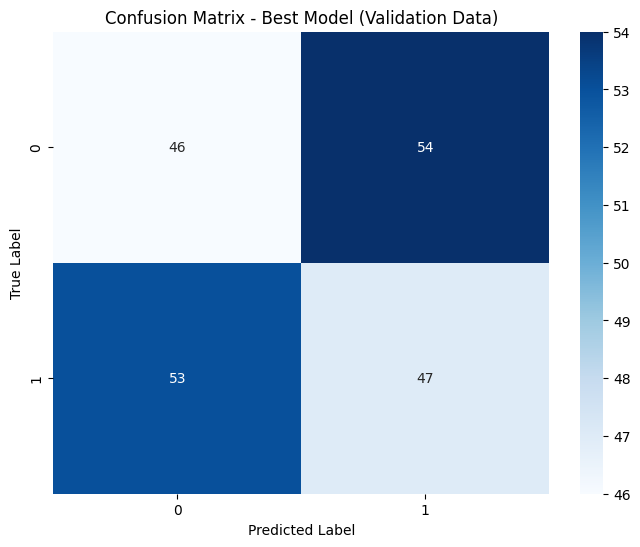

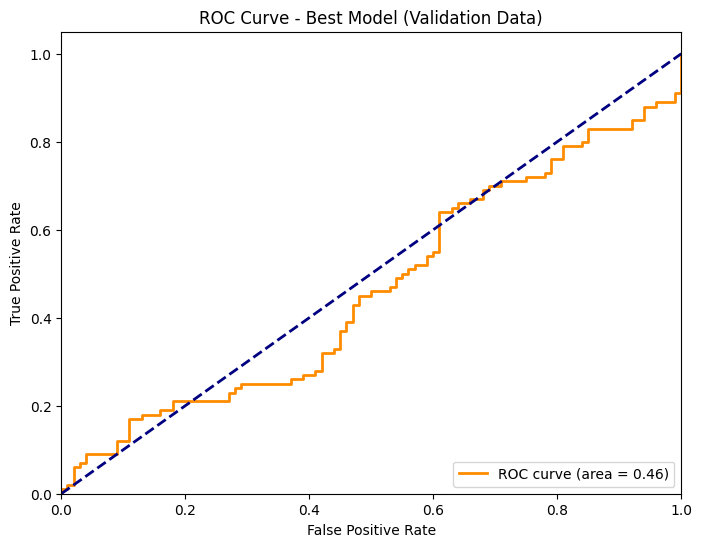

Best Hyperparameters:
filters1: 64
filters2: 128
filters3: 128
units: 256
learning_rate: 0.0007930365245758902


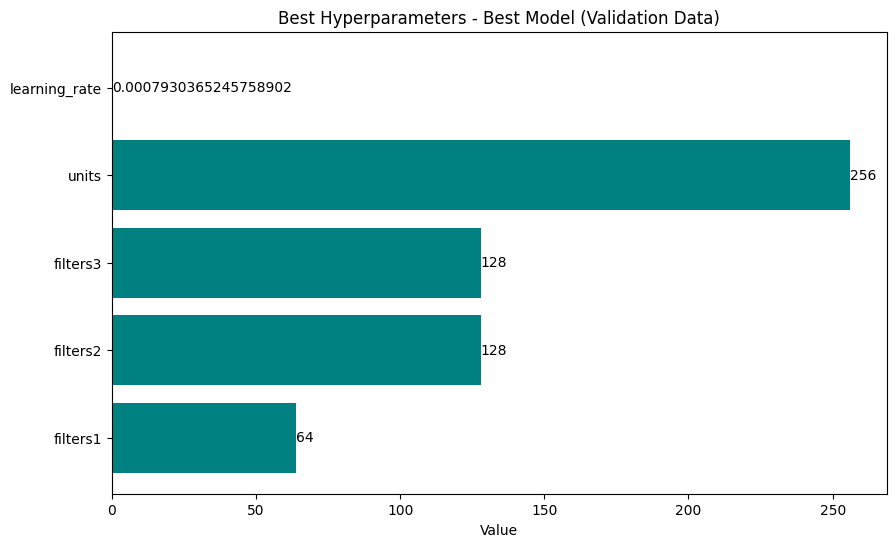

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

# Generate predictions using the best model on the validation set
y_pred = best_model.predict(validation_generator)
y_pred_classes = np.round(y_pred).astype(int)  # Convert probabilities to binary predictions (0 or 1)
y_true = validation_generator.classes  # True labels
categories = list(validation_generator.class_indices.keys())  # Class names (e.g., '0' and '1')

# Calculate accuracy
accuracy = np.mean(y_pred_classes.flatten() == y_true)
print(f"Calculated Accuracy: {accuracy:.4f}")

# Print Classification Report
report = classification_report(y_true, y_pred_classes, target_names=categories)
print("Classification Report:")
print(report)

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix - Best Model (Validation Data)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Best Model (Validation Data)')
plt.legend(loc='lower right')
plt.show()

# Best Hyperparameters
best_params = {
    'filters1': int(best_hyperparameters.get('filters1')),
    'filters2': int(best_hyperparameters.get('filters2')),
    'filters3': int(best_hyperparameters.get('filters3')),
    'units': int(best_hyperparameters.get('units')),
    'learning_rate': best_hyperparameters.get('learning_rate')
}

print("Best Hyperparameters:")
for key, value in best_params.items():
    print(f"{key}: {value}")

# Plot Best Hyperparameters
plt.figure(figsize=(10, 6))
params = list(best_params.keys())
values = list(best_params.values())
plt.barh(params, values, color='teal')

# Annotate values on the bar plot
for index, value in enumerate(values):
    plt.text(value, index, str(value), va='center', ha='left', fontsize=10, color='black')

plt.xlabel('Value')
plt.title('Best Hyperparameters - Best Model (Validation Data)')
plt.show()


BAR GRAPH

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import zipfile
import os

# Path to the ZIP file
zip_file_path = '/content/drive/My Drive/Heatmaps/bar_graphs.zip'
extract_path = '/content/bar_graphs'

# Verify if the ZIP file exists
if not os.path.exists(zip_file_path):
    raise FileNotFoundError(f"File not found: {zip_file_path}")

# Copy the ZIP file to Colab
!cp "{zip_file_path}" /content

# Unzip the file
with zipfile.ZipFile('/content/bar_graphs.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

# Paths
heatmaps_dir = '/content/bar_graphs'
categories = ['0', '1']

# Parameters
img_size = 64
sequence_length = img_size * img_size  # 64 * 64
batch_size = 32
epochs = 50

# Initialize lists to hold image data and labels
images = []
labels = []

# Read images and labels
for category in categories:
    category_path = os.path.join(heatmaps_dir, category)
    for filename in os.listdir(category_path):
        if filename.endswith('.png'):
            # Load image
            img_path = os.path.join(category_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
            img = cv2.resize(img, (img_size, img_size))  # Ensure the image is 64x64

            # Convert image to 1D array
            img_array = img_to_array(img).flatten()  # Flatten to 1D

            # Append to lists
            images.append(img_array)
            labels.append(int(category))

# Convert lists to NumPy arrays
X = np.array(images)
y = np.array(labels)

# Normalize the pixel values to [0, 1]
X = X / 255.0

# Reshape X to fit into 1D CNN (num_samples, sequence_length, num_features)
X = X.reshape((X.shape[0], sequence_length, 1))

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Conv1D(
        filters=hp.Int('filters_1', min_value=32, max_value=128, step=16),
        kernel_size=hp.Int('kernel_size_1', min_value=3, max_value=7, step=2),
        activation='relu',
        input_shape=(sequence_length, 1)
    ))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(
        filters=hp.Int('filters_2', min_value=32, max_value=128, step=16),
        kernel_size=hp.Int('kernel_size_2', min_value=3, max_value=7, step=2),
        activation='relu'
    ))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(
        filters=hp.Int('filters_3', min_value=32, max_value=128, step=16),
        kernel_size=hp.Int('kernel_size_3', min_value=3, max_value=7, step=2),
        activation='relu'
    ))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=32),
        activation='relu'
    ))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Define the tuner for Bayesian optimization
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Set the number of trials to 10
    directory='bayesian_tuning',
    project_name='cnn_1d'
)

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Perform the search
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
loss, accuracy = best_model.evaluate(X_val, y_val)
print(f'Best Validation Accuracy: {accuracy:.2f}')

# Print the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")

# Save the best model
best_model.save('/content/cnn_1d_model_best.h5')


Trial 10 Complete [00h 00m 12s]
val_accuracy: 0.8500000238418579

Best val_accuracy So Far: 0.875
Total elapsed time: 00h 01m 59s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8716 - loss: 0.3642


Best Validation Accuracy: 0.88
Best Hyperparameters:
filters_1: 48
kernel_size_1: 5
filters_2: 128
kernel_size_2: 7
filters_3: 48
kernel_size_3: 7
dense_units: 160


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87        96
           1       0.88      0.88      0.88       104

    accuracy                           0.88       200
   macro avg       0.87      0.88      0.87       200
weighted avg       0.88      0.88      0.88       200



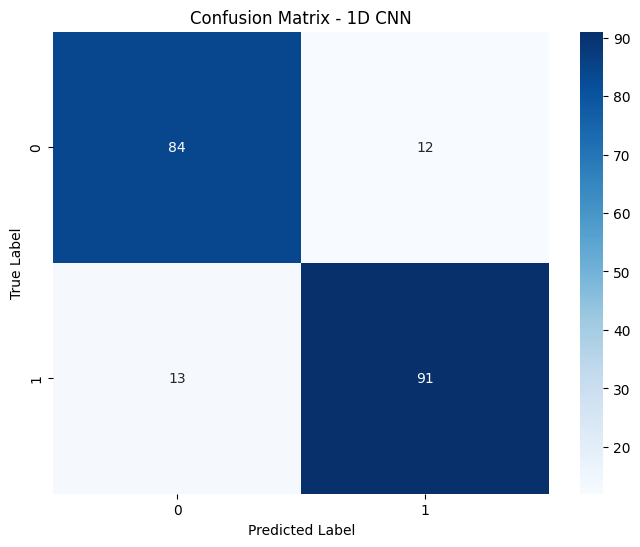

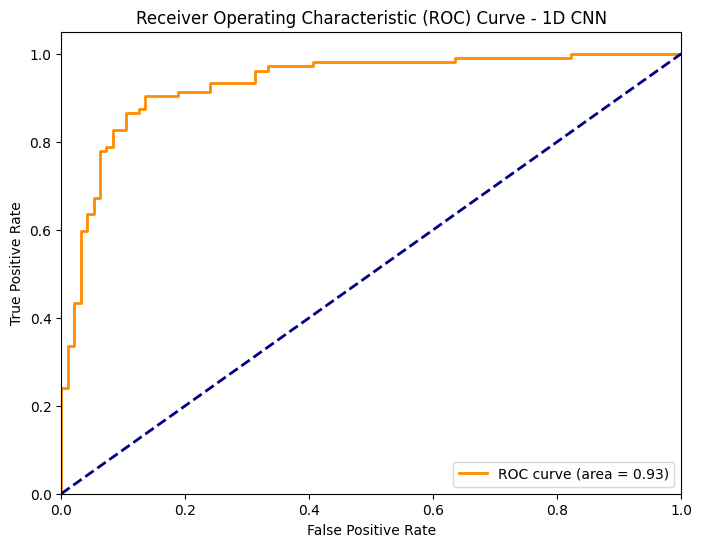

Best Hyperparameters:
filters_1: 48
kernel_size_1: 5
filters_2: 128
kernel_size_2: 7
filters_3: 48
kernel_size_3: 7
dense_units: 160
Best Validation Accuracy: 0.88


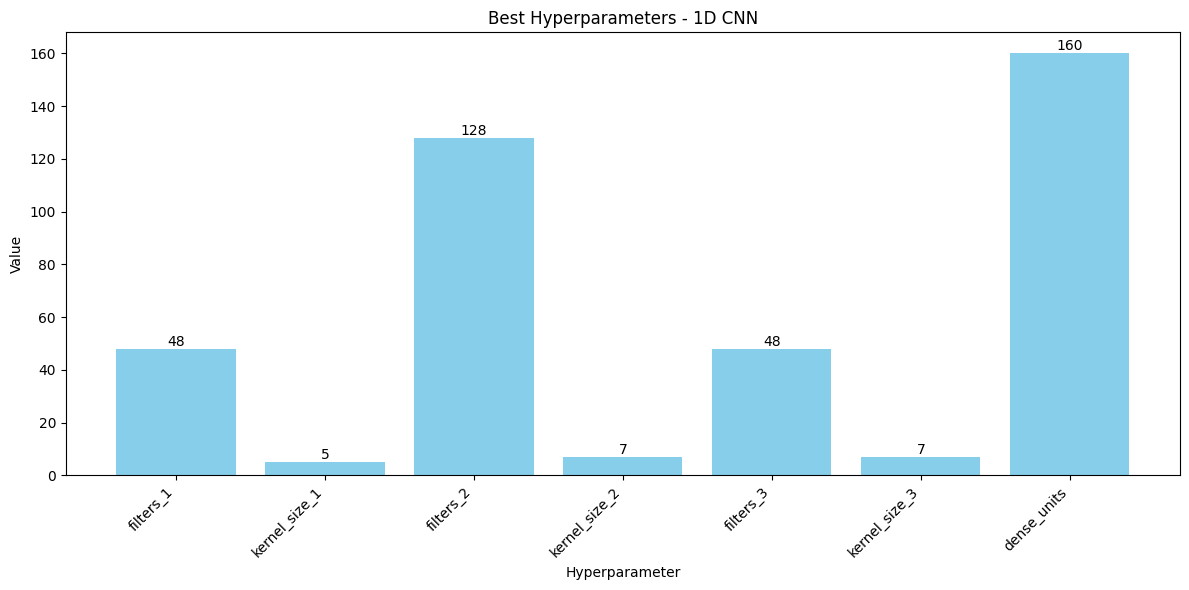

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

# Generate predictions
y_pred = best_model.predict(X_val)
y_pred_classes = np.round(y_pred).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_pred_classes, target_names=categories))

# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix - 1D CNN')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('/content/confusion_matrix.png')  # Save confusion matrix plot
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - 1D CNN')
plt.legend(loc='lower right')
plt.savefig('/content/roc_curve.png')  # Save ROC curve plot
plt.show()

# Print the best parameters
print("Best Hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")

# Print the best validation accuracy
print(f'Best Validation Accuracy: {accuracy:.2f}')

# Plot best hyperparameters with value annotations
hyperparameters = best_hyperparameters.values
keys = list(hyperparameters.keys())
values = [int(value) for value in hyperparameters.values()]  # Convert values to integers

plt.figure(figsize=(12, 6))
bars = plt.bar(keys, values, color='skyblue')

# Adding value annotations on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval}', ha='center', va='bottom')  # Show as integer

plt.xlabel('Hyperparameter')
plt.ylabel('Value')
plt.title('Best Hyperparameters - 1D CNN')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/content/best_hyperparameters.png')  # Save hyperparameters plot
plt.show()


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import kerastuner as kt

# Paths
base_dir = '/content/bar_graphs'
categories = ['0', '1']

# Parameters
img_size = 64
batch_size = 32
epochs = 50

# Data Generator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Split the data into 80% training and 20% validation
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Now split 80% of the training set further into 80% train and 20% test
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)  # 0.25 of training = 20% of original

train_generator_further = test_datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Define model building function for KerasTuner
def build_model(hp):
    model = Sequential([
        Conv2D(hp.Int('filters1', min_value=32, max_value=64, step=32), (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(hp.Int('filters2', min_value=64, max_value=128, step=64), (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(hp.Int('filters3', min_value=128, max_value=256, step=128), (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(hp.Int('units', min_value=256, max_value=512, step=128), activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(hp.Float('learning_rate', min_value=1e-5, max_value=1e-1, sampling='LOG')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Initialize Keras Tuner
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='/content/keras_tuner',
    project_name='cnn_tuning'
)

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Search for the best hyperparameters
tuner.search(
    train_generator_further,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=[early_stopping]
)

# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Evaluate the best model on the validation and test sets
val_loss, val_accuracy = best_model.evaluate(validation_generator)
test_loss, test_accuracy = best_model.evaluate(test_generator)

# Save the best model
best_model.save('/content/2d_cnn_model_best.h5')

# Save only validation accuracy
print(f'Validation Accuracy: {val_accuracy:.2f}')
print(f'Test Accuracy: {test_accuracy:.2f}')

# Print the best hyperparameters
print("Best hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")


Trial 10 Complete [00h 00m 20s]
val_accuracy: 0.8799999952316284

Best val_accuracy So Far: 0.8799999952316284
Total elapsed time: 00h 02m 22s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8675 - loss: 0.3639
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.8889 - loss: 0.3435


Validation Accuracy: 0.88
Test Accuracy: 0.88
Best hyperparameters:
filters1: 64
filters2: 64
filters3: 128
units: 384
learning_rate: 0.0011011540721501195


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Calculated Accuracy: 0.4800
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.50      0.49       100
           1       0.48      0.46      0.47       100

    accuracy                           0.48       200
   macro avg       0.48      0.48      0.48       200
weighted avg       0.48      0.48      0.48       200



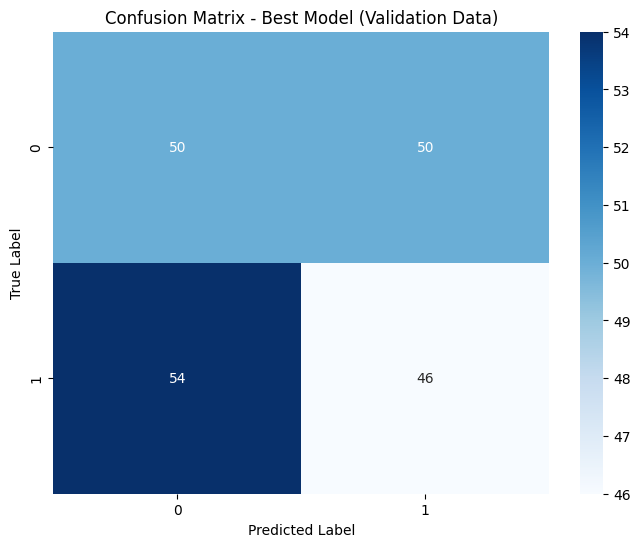

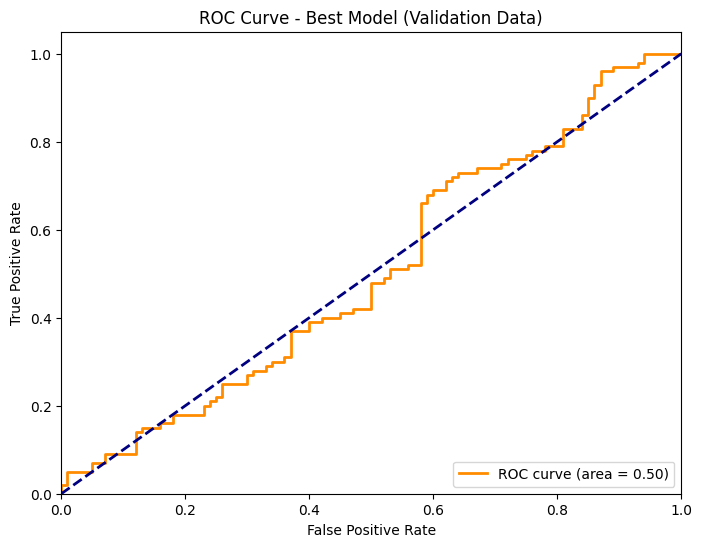

Best Hyperparameters:
filters1: 64
filters2: 64
filters3: 128
units: 384
learning_rate: 0.0011011540721501195


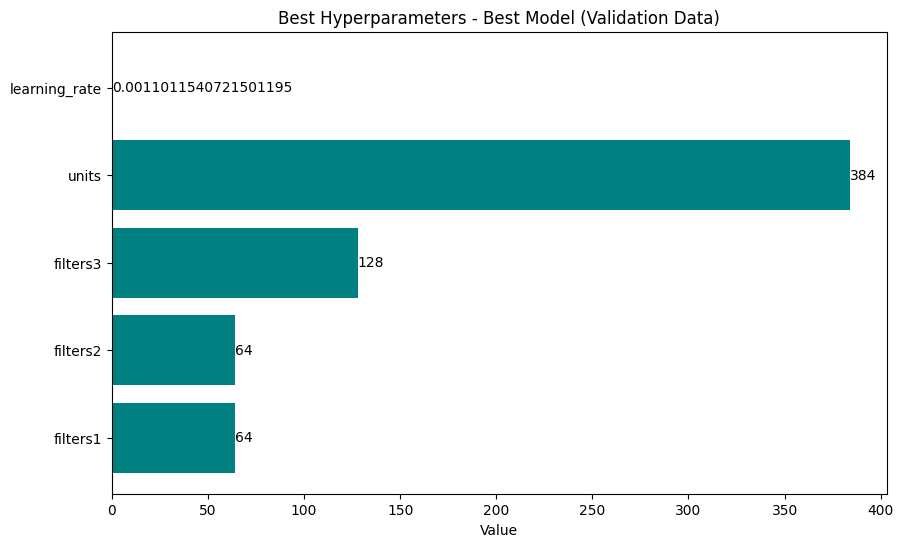

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

# Generate predictions using the best model on the validation set
y_pred = best_model.predict(validation_generator)
y_pred_classes = np.round(y_pred).astype(int)  # Convert probabilities to binary predictions (0 or 1)
y_true = validation_generator.classes  # True labels
categories = list(validation_generator.class_indices.keys())  # Class names (e.g., '0' and '1')

# Calculate accuracy
accuracy = np.mean(y_pred_classes.flatten() == y_true)
print(f"Calculated Accuracy: {accuracy:.4f}")

# Print Classification Report
report = classification_report(y_true, y_pred_classes, target_names=categories)
print("Classification Report:")
print(report)

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix - Best Model (Validation Data)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Best Model (Validation Data)')
plt.legend(loc='lower right')
plt.show()

# Best Hyperparameters
best_params = {
    'filters1': int(best_hyperparameters.get('filters1')),
    'filters2': int(best_hyperparameters.get('filters2')),
    'filters3': int(best_hyperparameters.get('filters3')),
    'units': int(best_hyperparameters.get('units')),
    'learning_rate': best_hyperparameters.get('learning_rate')
}

print("Best Hyperparameters:")
for key, value in best_params.items():
    print(f"{key}: {value}")

# Plot Best Hyperparameters
plt.figure(figsize=(10, 6))
params = list(best_params.keys())
values = list(best_params.values())
plt.barh(params, values, color='teal')

# Annotate values on the bar plot
for index, value in enumerate(values):
    plt.text(value, index, str(value), va='center', ha='left', fontsize=10, color='black')

plt.xlabel('Value')
plt.title('Best Hyperparameters - Best Model (Validation Data)')
plt.show()


GSGD

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the CNN model
def create_model():
    model = models.Sequential([
        layers.Input(shape=(64, 64, 1)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(2, activation='softmax')  # Binary classification with 2 output units
    ])
    return model

# Load and preprocess the dataset
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator = datagen.flow_from_directory(
    '/content/AlgX3_64x64_merged_tensors_with_labels',
    target_size=(64, 64),
    color_mode='grayscale',
    batch_size=32,
    class_mode='sparse',  # Use 'sparse' for integer labels
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    '/content/AlgX3_64x64_merged_tensors_with_labels',
    target_size=(64, 64),
    color_mode='grayscale',
    batch_size=32,
    class_mode='sparse',  # Use 'sparse' for integer labels
    subset='validation'
)

# Compile and train the model with the correct loss function
model = create_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_generator, epochs=10, validation_data=validation_generator)

# Evaluate the model
test_loss, test_acc = model.evaluate(validation_generator)
print(f'Test accuracy: {test_acc}')


Found 6958 images belonging to 2 classes.
Found 773 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


218/218 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.5956 - loss: 0.6382 - val_accuracy: 0.8486 - val_loss: 0.3729
Epoch 2/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8391 - loss: 0.3756 - val_accuracy: 0.8499 - val_loss: 0.3536
Epoch 3/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8524 - loss: 0.3433 - val_accuracy: 0.8642 - val_loss: 0.3129
Epoch 4/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8831 - loss: 0.2940 - val_accuracy: 0.8655 - val_loss: 0.3190
Epoch 5/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8805 - loss: 0.2928 - val_accuracy: 0.8913 - val_loss: 0.2795
Epoch 6/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8842 - loss: 0.2861 - val_accuracy: 0.8693 - val_loss: 0.3147
Epoch 7/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8986 - loss: 0.2593 - val_accuracy: 0.8875 - val_loss: 0.2612
Epoch 8/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8974 - loss: 0.2537 - val_accuracy: 0.89

In [ ]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.6 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import SGD
import keras_tuner as kt

def build_model(hp):
    model = models.Sequential([
        layers.Input(shape=(64, 64, 1)),
        layers.Conv2D(hp.Int('conv_1_filters', min_value=16, max_value=64, step=16), (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(hp.Int('conv_2_filters', min_value=32, max_value=128, step=32), (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(hp.Int('conv_3_filters', min_value=64, max_value=256, step=64), (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(hp.Int('dense_units', min_value=64, max_value=256, step=64), activation='relu'),
        layers.Dense(2, activation='softmax')
    ])

    optimizer = SGD(
        learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-1, sampling='LOG'),
        momentum=hp.Float('momentum', min_value=0.0, max_value=0.9, step=0.1)
    )

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [ ]:
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    num_initial_points=10,
    directory='my_dir',
    project_name='intro_to_kt'
)

tuner.search(train_generator, epochs=10, validation_data=validation_generator)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")


Trial 12 Complete [00h 00m 45s]
val_accuracy: 0.9016817808151245

Best val_accuracy So Far: 0.9055627584457397
Total elapsed time: 00h 09m 06s

Search: Running Trial #13

Value             |Best Value So Far |Hyperparameter
16                |48                |conv_1_filters
32                |32                |conv_2_filters
256               |256               |conv_3_filters
64                |256               |dense_units
0.1               |0.032538          |learning_rate
0                 |0.6               |momentum

Epoch 1/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.6498 - loss: 0.6202 - val_accuracy: 0.8473 - val_loss: 0.3848
Epoch 2/10
117/218 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8486 - loss: 0.3820